# OHP_3_GetZeroPointFromStellarField

[Version Hervé Dole, Université Paris-Saclay - 20240324]

Thanks to Henry J McCracken and M2 astrophysique AAIS IDF OHP1 team for inspiration on some code lines

Détermine le point zero ZP sur des données de champs stellaires avec WCS


## Need a fully processed with WCS fits file of a star field

In [103]:
# Source Detection and Aperture Photometry and Zero Point for OHP1
# updated H. Dole 20221217 20240312
# sources: Henry + https://sep.readthedocs.io/en/v1.1.x/tutorial.html
# also https://docs.astropy.org/en/stable/coordinates/matchsep.html
# also https://astroquery.readthedocs.io/en/latest/
# also https://docs.astropy.org/en/stable/coordinates/matchsep.html#matching-catalogs
# also https://docs.astropy.org/en/stable/io/ascii/write.html
# also https://docs.astropy.org/en/stable/io/ascii/read.html

# Set up and import appropriate packages
import numpy as np
import sep
from astropy import wcs
from astropy.io import fits
from astropy.io import ascii
from astropy.table import Table, join
#from astropy.table import Column
from astropy import units as u
from astropy.coordinates import SkyCoord

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = [10., 8.]

from scipy import stats

import astroquery
from astroquery.vizier import Vizier
from astroquery.xmatch import XMatch


## Put Path and File here

In [104]:
# path for OHP T120 data
# CHANGE HERE WITH YOUR DATA PATH
#path_data_ohp = "/Users/sst/OHP/202103OHP1_M2/DATA/T120/20210303/"
path_data_ohp = "./data/"

In [105]:
# FITS file of processed and coadded data in one band
# CHANGE HERE WITH YOUR FINAL REDUCED AND COADDED WITH WCS DATA FILE
file_ohp = "NGC_2420-0001_R40_wcs.fits"
#file_ohp = "NGC_2420-0001_G150_wcs.fits"


## 1. Read data of a stellar calibration field 

In [106]:
data, header = fits.getdata(path_data_ohp+file_ohp,0,header=True)

In [107]:
# remove nans and replace by mean 
#data = data[np.isnan(data)]
data = np.nan_to_num(data, nan=np.nanmean(data))

In [108]:
# get exposure time 
exptime = header['EXPTIME']
#header['EXPOSURE']

In [109]:
# normalize data by exptime to get 1 second (like OHP_1) IF NOT DONE ALREADY (don't do it twice !)
data = data / exptime

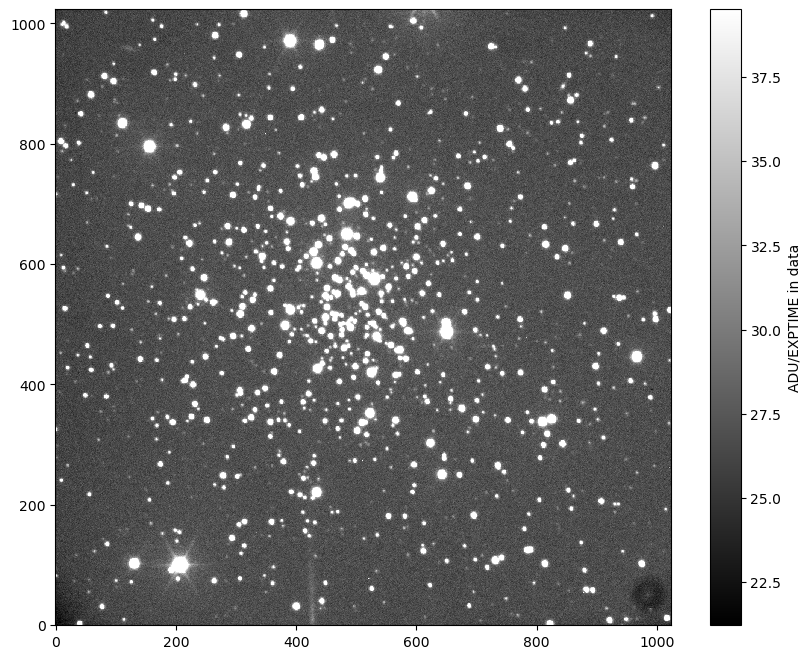

In [110]:
# display the image
sig = 0.2
m, s = np.mean(data), np.std(data)
plt.imshow(data, interpolation='nearest', cmap='gray', vmin=m-sig*s, vmax=m+sig*s, origin='lower')
plt.colorbar(label="ADU/EXPTIME in data")
plt.show()

In [111]:
#reorder bytes because of fits instead of cfitsio
#data = data.byteswap().newbyteorder()


In [112]:
# convert uint array into float for sep package (otherwise sep.Background breaks)
data = data.astype('f', copy=True)

## 2. Background Subtraction 

In [113]:
# measure a spatially varying background on the image
bkg = sep.Background(data)
bkg = sep.Background(data, bw=128, bh=128, fw=9, fh=9)


In [114]:
# get a "global" mean and noise of the image background (in ADU):
print(bkg.globalback)
print(bkg.globalrms)


26.843719482421875
0.7719634771347046


In [115]:
# evaluate background as 2-d array, same size as original image
bkg_image = bkg.back()


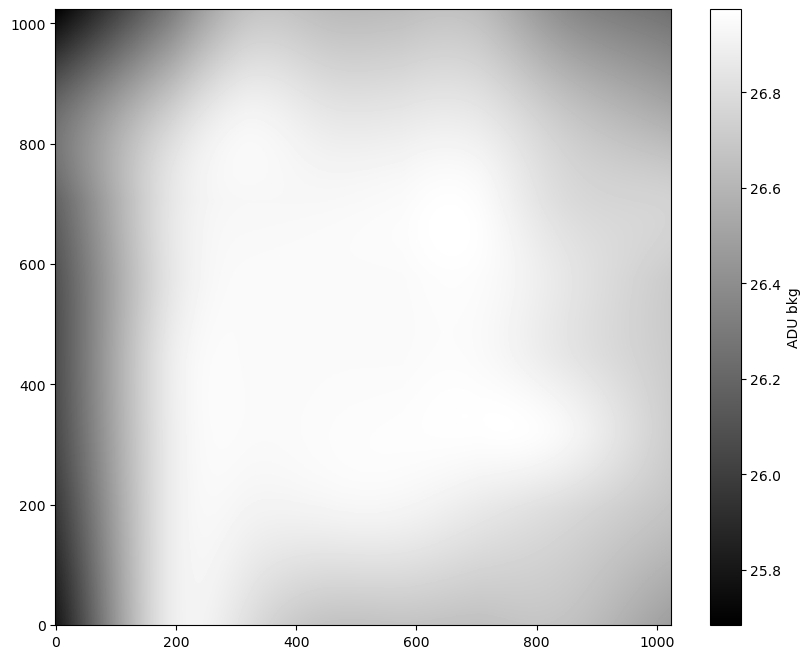

In [116]:
# display the background
plt.imshow(bkg_image, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar(label='ADU bkg');
plt.show()

In [117]:
# subtract the background
data_sub = data - bkg

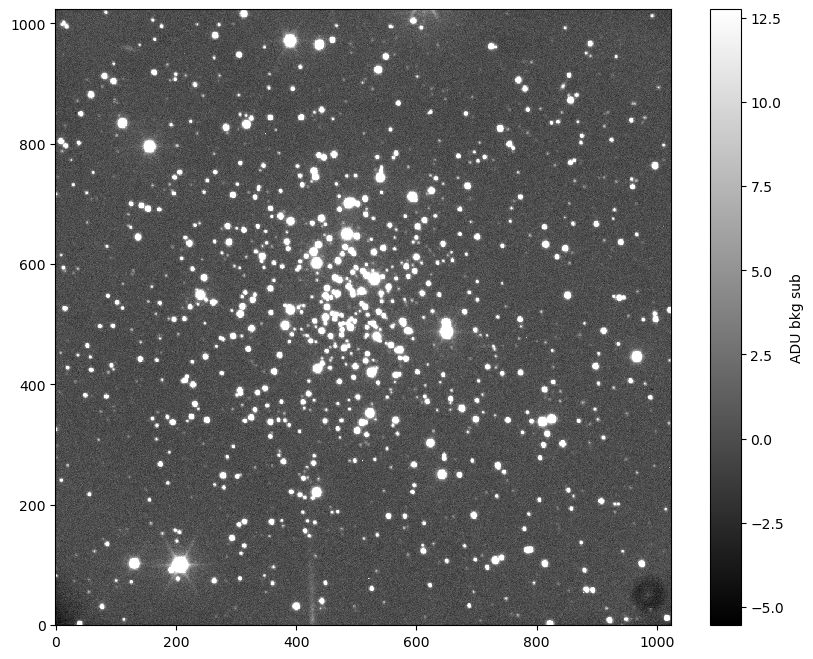

In [118]:
# check subtraction looks good with zero mean
# show the image
m_sub, s_sub = np.mean(data_sub), np.std(data_sub)
plt.imshow(data_sub, interpolation='nearest', cmap='gray', vmin=m_sub-sig*s_sub, vmax=m_sub+sig*s_sub, origin='lower')
plt.colorbar(label='ADU bkg sub');

plt.show()

## 3. Source Detection with sep

In [119]:
# Now Object detection
objects = sep.extract(data_sub, 5., err=bkg.globalrms)

In [120]:
# how many objects were detected
len(objects)

765

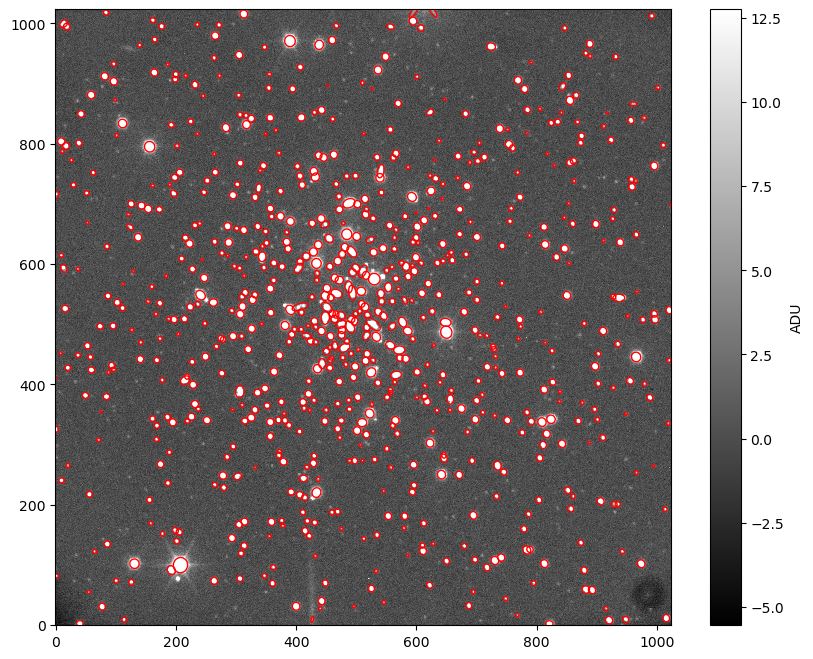

In [121]:
# Show / Display detected objects in red on the bkg subtracted map
from matplotlib.patches import Ellipse

# plot background-subtracted image
fig, ax = plt.subplots()
m, s = np.median(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray',
               vmin=m-sig*s, vmax=m+sig*s, origin='lower')
fig.colorbar(im, ax=ax, label='ADU');

# plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)



In [122]:
# available fields in objects: lots of informations!
#objects.dtype.names

In [123]:
#objects

## 4. Aperture Photometry with sep

In [124]:
#Finally, we’ll perform simple circular aperture photometry with a 5 pixel radius at the locations of the objects:
flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'], objects['y'],
                                     5.0, err=bkg.globalrms, gain=1.0)


In [125]:
#Print all x, y positions, flux measurements, S/N:
for i in range(len(objects)):
    print("object {:d}: x= {:f} y= {:f} flux = {:f} +/- {:f} S/N = {:f}".format(i, objects['x'][i], objects['y'][i], flux[i], fluxerr[i], flux[i]/fluxerr[i]) )

object 0: x= 40.653798 y= 2.379231 flux = 3038.639268 +/- 55.481179 S/N = 54.768830
object 1: x= 820.902012 y= 2.197540 flux = 10808.421272 +/- 104.148882 S/N = 103.778562
object 2: x= 114.428189 y= 8.584102 flux = 364.759096 +/- 20.287315 S/N = 17.979663
object 3: x= 426.867795 y= 9.387740 flux = 237.590694 +/- 16.863657 S/N = 14.088919
object 4: x= 947.621603 y= 9.082441 flux = 818.400527 +/- 29.413349 S/N = 27.824119
object 5: x= 919.909145 y= 7.920380 flux = 4882.797172 +/- 70.212053 S/N = 69.543575
object 6: x= 1014.995201 y= 11.383690 flux = 5583.051583 +/- 75.031809 S/N = 74.409130
object 7: x= 767.494471 y= 16.280623 flux = 177.873910 +/- 14.994432 S/N = 11.862664
object 8: x= 439.766208 y= 27.369928 flux = 175.375936 +/- 14.906106 S/N = 11.765375
object 9: x= 914.810318 y= 27.262170 flux = 214.081801 +/- 16.148644 S/N = 13.256953
object 10: x= 495.976320 y= 30.971696 flux = 122.184490 +/- 12.999105 S/N = 9.399454
object 11: x= 77.689012 y= 30.352647 flux = 2413.424872 +/- 49.6

In [126]:
# just checking one variable
objects['flux']


array([3.06057129e+03, 1.11997422e+04, 2.89045776e+02, 7.30261612e+01,
       7.79251465e+02, 5.18729297e+03, 5.80015576e+03, 9.16243439e+01,
       7.33999634e+01, 1.31341858e+02, 5.21341667e+01, 2.48024097e+03,
       9.17378174e+02, 1.49231562e+04, 8.14347839e+01, 4.21001758e+03,
       1.60187698e+02, 6.90199814e+01, 1.30575012e+02, 2.71694067e+03,
       3.97240527e+03, 1.75679626e+03, 8.85356812e+02, 2.48927582e+02,
       9.07292847e+02, 1.03667883e+03, 4.91810059e+02, 2.28545120e+02,
       3.35821899e+03, 1.01312445e+03, 1.59815353e+02, 2.08592545e+02,
       8.94548264e+01, 1.35030322e+03, 3.41154907e+02, 1.57333301e+03,
       8.93848633e+03, 8.23904785e+03, 1.03285718e+03, 6.66301147e+02,
       7.70969219e+04, 9.48800354e+01, 3.65145645e+01, 1.80244277e+04,
       3.70174438e+03, 4.92713184e+03, 1.97581250e+05, 5.70917542e+02,
       1.21743362e+02, 2.19299469e+02, 7.70476172e+03, 3.76321875e+03,
       4.53125000e+02, 4.36956689e+03, 2.60112183e+02, 1.38089734e+03,
      

## 5. Check S/N of detections

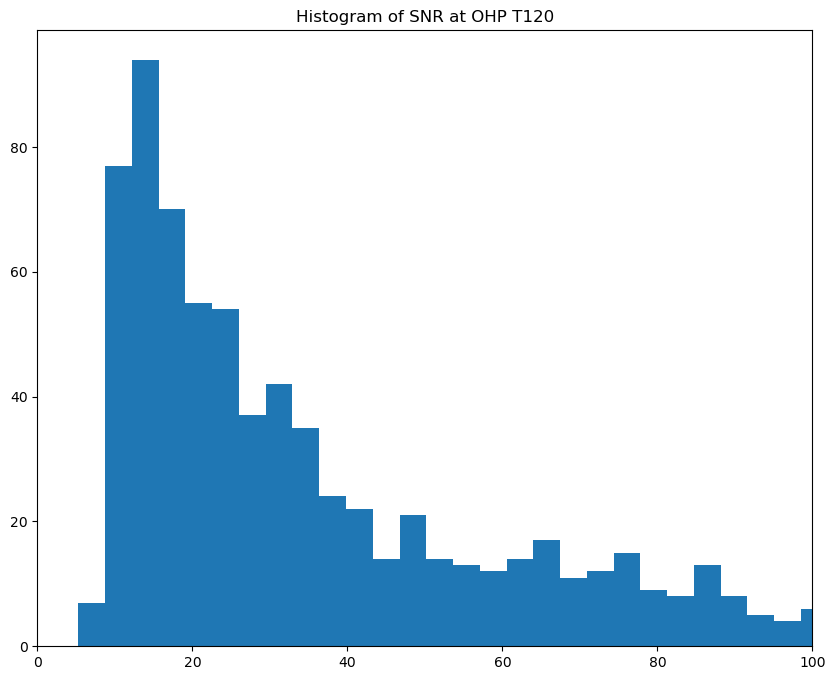

In [127]:
n_snr, bins_snr, patches_snr  = plt.hist(flux/fluxerr, 100)
plt.xlim(0, 100)
plt.title('Histogram of SNR at OHP T120')
plt.show()

## 6. Now use WCS to get RA, DEC of detected sources

In [128]:
# upload header in the variable w suitable for the rest
w = wcs.WCS(header)


In [129]:
# print w so we make sure all teh WCS information is here
print(w)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP' 'DEC--TAN-SIP' 
CRVAL : 114.566437794 21.554709132 
CRPIX : 634.593338013 620.538902283 
CD1_1 CD1_2  : -0.000213907902729 3.45964700299e-08 
CD2_1 CD2_2  : -7.20027453506e-08 -0.000213930241464 
NAXIS : 1024  1024


In [130]:
# reformat x and y in a numpy array
pairs=np.vstack((objects['x'],objects['y'])).T


In [131]:
# convert pairs of x and y into ra, dec in wrd
wrd = w.wcs_pix2world(pairs,0)

In [132]:
#print(len(wrd))

In [133]:
# create arrays of ra, dec : prepare input data for cross matching with databases
ra = [radec[0] for radec in wrd]
dec = [radec[1] for radec in wrd]

## 7. Cross-match ra, dec of detected sources with databases in CDS / Vizier

In [134]:
table_in=Table([ra,dec,flux], names =['ra_in','dec_in','flux_in'])


In [135]:
table_out = XMatch.query(cat1=table_in, cat2='vizier:II/349/ps1',max_distance=0.3 * u.arcsec, 
                     colRA1='ra_in',colDec1='dec_in')

In [136]:
#PAN-STARRS survey
#table_out = XMatch.query(cat1=table_in, cat2='vizier:II/349/ps1',max_distance=0.3 * u.arcsec, 
#                     colRA1='ra_in',colDec1='dec_in')

In [137]:
#SDSS survey
#table_out = XMatch.query(cat1=table_in, cat2='vizier:V/147/sdss12',max_distance=0.3 * u.arcsec, 
#                     colRA1='ra_in',colDec1='dec_in')

In [138]:
#APASS data
#table_out = XMatch.query(cat1=table_in, cat2='vizier:II/336/apass9',max_distance=0.3 * u.arcsec, 
#                     colRA1='ra_in',colDec1='dec_in')

## 8. Now compare instrumental flux (magnitudes) to databases, make a regression and find zero point

### Check filter

In [139]:
# select reasonable range of r magnitudes
#select=((table_out['rmag']>15) & (table_out['rmag']<20))
#select=((table_out['gmag']>15) & (table_out['gmag']<20))


In [140]:
# get mag instrumentale from OHP
maginstru = -2.5*np.log10(table_out['flux_in'])
# get rmag from database
rmag = table_out['rmag']
#rmag = table_out['gmag']

# compute regression to get slope and zero point
slope, intercept, r, p, se = stats.linregress(maginstru,rmag)
print(intercept, slope)
# slope should be ~1

24.4938530922856 1.0426102808032305


## 9. Get ZP ! 

In [141]:
# get long awaited zero point !
zp_r = intercept
print('zero point = ', zp_r)

zero point =  24.4938530922856


## 10. Checks on magnitude

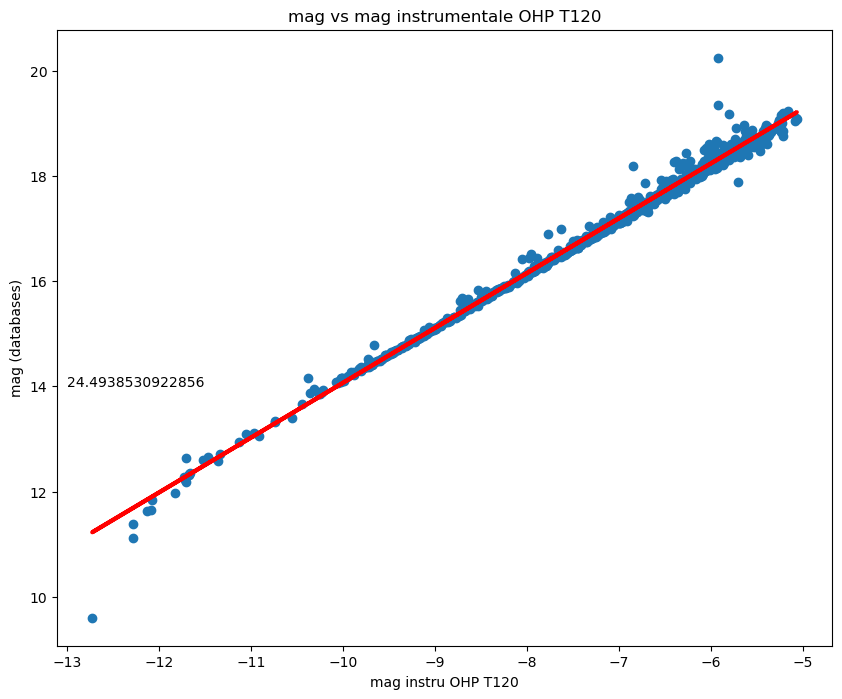

In [142]:
# show x= mag instrumentale; y= rmag from databases
plt.scatter(maginstru,rmag)
plt.plot(maginstru,maginstru*slope+intercept,c='r',lw=3)
plt.title("mag vs mag instrumentale OHP T120")
plt.xlabel("mag instru OHP T120")
plt.ylabel("mag (databases)")
plt.text(-13, 14, intercept)
plt.show()


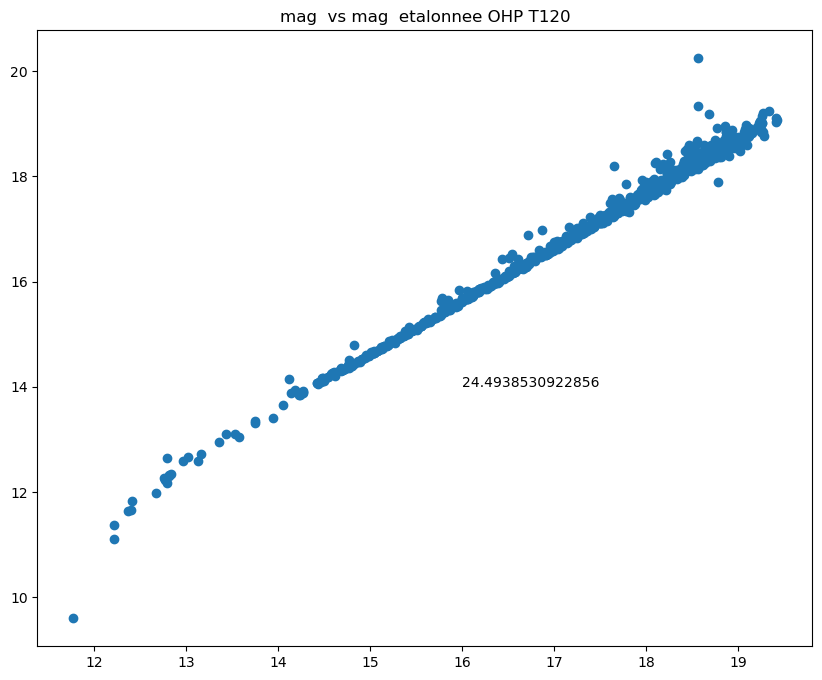

In [143]:
# check it's OK with a plot
plt.scatter(maginstru + zp_r,rmag)
plt.text(16, 14, zp_r)
plt.title("mag  vs mag  etalonnee OHP T120")
plt.show()

In [144]:
# what's in table from database ?
#table_out

In [145]:
#table_in